Using wradlib to obtain PBB and CBB, testing the terrain display of GeoTIFF file.

Code has been adapted by code from a notebook by Scott Collis:
https://github.com/EVS-ATMOS/ARM-Azores/blob/master/notebooks/2.%20Terrain%20of%20ENA.ipynb

Code for projection conversion by Kai Muehlbauer and Wradlib notebook by Kai: 
http://wradlib.org/wradlib-docs/latest/notebooks/beamblockage/wradlib_beamblock.html

And Code by Nick Guy from PyRadarMet:
https://github.com/nguy/PyRadarMet

In [1]:
import gdal
import osr
import numpy as np
import netCDF4
import re
import pyart
import matplotlib
import wradlib as wrl
import mayavi.mlab as mylab

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/traitsui/ui_traits.py:327: DeprecationWarning: use "HasTraits.trait_set" instead
  self.set( left = left, right = right, top = top, bottom = bottom )
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/traitsui/ui_traits.py:327: DeprecationWarning: use "HasTraits.trait_set" instead
  self.set( left = left, right = right, top = top, bottom = bottom )
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/traitsui/ui_traits.py:422: DeprecationWarning: use "HasTraits.trait_get" instead
  dv = ( self.klass, (), dv.get() )
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/traitsui/ui_traits.py:422: DeprecationWarning: use "HasTraits.trait_get" instead
  dv = ( self.klass, (), dv.get() )
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/traitsui/ui_traits.py:422: DeprecationWarning: use "HasTraits.trait_get" instead
  dv = ( self.klass, (), dv.ge

In [2]:
def convertXY(xy_source, inproj, outproj):
    # function to convert coordinates

    shape = xy_source[0, :, :].shape
    size = xy_source[0, :, :].size

    # the ct object takes and returns pairs of x,y, not 2d grids
    # so the the grid needs to be reshaped (flattened) and back.
    ct = osr.CoordinateTransformation(inproj, outproj)
    xy_target = np.array(ct.TransformPoints(xy_source.reshape(2, size).T))

    xx = xy_target[:, 0].reshape(shape)
    yy = xy_target[:, 1].reshape(shape)

    return xx, yy

In [3]:
ds = gdal.Open("/home/zsherman/seattle.tif")

data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()


xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5

ds = None

# create a grid of xy coordinates in the original projection
xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]

In [4]:
print(xy_source.shape)

In [5]:
proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [6]:
# Currently consumes too much memory.
"""
# Create the figure and basemap object

llcrnrlat=46.5
urcrnrlon=-120.5
llcrnrlon=-124.1
urcrnrlat=49.0
lats = np.arange(llcrnrlat, urcrnrlat, .5)
lons = np.arange(llcrnrlon, urcrnrlon, .5)
m = Basemap(
    projection='lcc', lon_0=-122.4959, lat_0=48.1946,
    resolution='l', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
    urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)
# Create the projection objects for the convertion
# original (Albers)
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

fig = plt.figure(figsize=(12, 6))

elev = data.T
the_sea = data.T < 0.1
masked_data = np.ma.masked_where(the_sea, elev)


# plot the data (first layer)
im1 = m.pcolormesh(xx, yy, 
                   masked_data, cmap=plt.cm.terrain)
plt.colorbar(label = 'Elevation above MSL (m)')
# labels = [left,right,top,bottom]
m.drawparallels(lats, labels=[True,False,False,False])
m.drawmeridians(lons, labels=[False,False,False,True])
# annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)
plt.gca().set_axis_bgcolor('aqua')
"""

"\n# Create the figure and basemap object\n\nllcrnrlat=46.5\nurcrnrlon=-120.5\nllcrnrlon=-124.1\nurcrnrlat=49.0\nlats = np.arange(llcrnrlat, urcrnrlat, .5)\nlons = np.arange(llcrnrlon, urcrnrlon, .5)\nm = Basemap(\n    projection='lcc', lon_0=-122.4959, lat_0=48.1946,\n    resolution='l', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,\n    urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)\n# Create the projection objects for the convertion\n# original (Albers)\ninproj = osr.SpatialReference()\ninproj.ImportFromWkt(proj)\n\n# Get the target projection from the basemap object\noutproj = osr.SpatialReference()\noutproj.ImportFromProj4(m.proj4string)\n\n# Convert from source projection to basemap projection\nxx, yy = convertXY(xy_source, inproj, outproj)\n\nfig = plt.figure(figsize=(12, 6))\n\nelev = data.T\nthe_sea = data.T < 0.1\nmasked_data = np.ma.masked_where(the_sea, elev)\n\n\n# plot the data (first layer)\nim1 = m.pcolormesh(xx, yy, \n                   masked_data, cmap=plt.cm.terrain)\nplt.co

### Using wradlib to determine PBB, CBB, create plots of each at a elevation angle and an array of elevation angles.

In [7]:
radar = pyart.io.read('/home/zsherman/beam_block/data/seattle_radar.nc')

In [8]:
radar.altitude

{'data': array([ 195.]),
 'long_name': 'Altitude',
 'positive': 'up',
 'standard_name': 'Altitude',
 'units': 'meters'}

In [9]:
radar.fixed_angle

{'data': array([ 0.5]),
 'long_name': 'Target angle for sweep',
 'standard_name': 'target_fixed_angle',
 'units': 'degrees'}

In [10]:
sitecoords = (-122.4959, 48.1946, 195.0)

In [11]:
nrays = 360
nbins = 1832
el = 0.5
bw = 1
range_res = 250

In [12]:
r = np.linspace(2125, (nbins - 1)*range_res + 2125, nbins)
#r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [13]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
lon, lat, alt = wrl.georef.polar2lonlatalt_n(
    coord[..., 0], np.degrees(coord[..., 1]),
    coord[..., 2], sitecoords)
print("lon, lat, alt:", lon.shape, lat.shape, alt.shape)

In [14]:
rasterfile = '/home/zsherman/seattle.tif'

In [15]:
data_raster = wrl.io.open_raster(rasterfile)

In [16]:
proj_raster = wrl.georef.wkt_to_osr(data_raster.GetProjection())

In [17]:
x_pol, y_pol = wrl.georef.reproject(lon, lat, projection_target=proj_raster)

In [18]:
x_pol

array([[-122.49588527, -122.49585582, -122.49582636, ..., -122.43729252,
        -122.43725765, -122.43722277],
       [-122.49585582, -122.49576747, -122.49567911, ..., -122.32010057,
        -122.31999597, -122.31989137],
       [-122.49582639, -122.49567916, -122.49553192, ..., -122.20297767,
        -122.2028034 , -122.20262912],
       ..., 
       [-122.49597361, -122.49612084, -122.49626808, ..., -122.78882233,
        -122.7889966 , -122.78917088],
       [-122.49594418, -122.49603253, -122.49612089, ..., -122.67169943,
        -122.67180403, -122.67190863],
       [-122.49591473, -122.49594418, -122.49597364, ..., -122.55450748,
        -122.55454235, -122.55457723]])

In [19]:
polcoords = np.dstack((x_pol, y_pol))
print("Polcoords:", polcoords.shape)

In [20]:
wrl.georef._get_range_resolution(r)

250.0

In [21]:
rlimits = (x_pol.min(), y_pol.min(), x_pol.max(), y_pol.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (y_pol.max(), x_pol.min(), x_pol.max(), y_pol.min()))

In [22]:
rastercoords, rastervalues = wrl.io.read_raster_data(rasterfile)

In [23]:
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

In [24]:
# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart2irregular_spline(
    rastercoords, rastervalues, polcoords,
    order=3, prefilter=False)

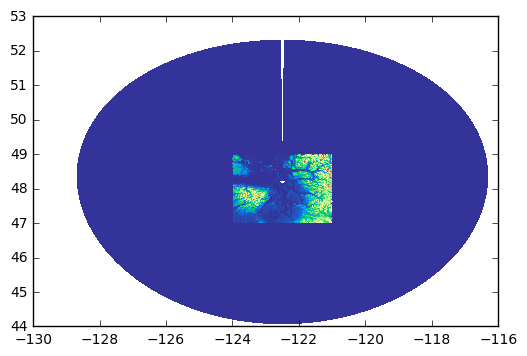

In [25]:
im2 = plt.pcolormesh(x_pol, y_pol, 
                     polarvalues, cmap=plt.cm.terrain)

In [26]:
polarvalues.shape

(360, 1832)

In [27]:
beam_height = wrl.qual.beam_height_ft(r, el)

In [28]:
elev = polarvalues
the_sea = polarvalues < 0.1
masked_pol_data = np.ma.masked_where(the_sea, elev)

In [29]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

In [30]:
maxindex = np.nanargmax(PBB, axis=1)
CBB = np.copy(PBB)

# Iterate over all beams
for ii, index in enumerate(maxindex):
    premax = 0.
    for jj in range(index):
        # Only iterate to max index to make this faster
        if PBB[ii, jj] > premax:
            CBB[ii, jj] = PBB[ii, jj]
            premax = PBB[ii, jj]
        else:
            CBB[ii, jj] = premax
    # beyond max index, everything is max anyway
    CBB[ii, index:] = PBB[ii, index]

In [31]:
# Also currently consumes too much memory.
"""
ds = gdal.Open('/home/zsherman/.tif')
data = ds.ReadAsArray()
the_sea = data < 0.1
masked_data = np.ma.masked_where(the_sea, data)
mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))

mlab.surf(masked_data, warp_scale=0.2)
mlap.points3d(x_pol, )
mlab.show()
"""

"\nds = gdal.Open('/home/zsherman/.tif')\ndata = ds.ReadAsArray()\nthe_sea = data < 0.1\nmasked_data = np.ma.masked_where(the_sea, data)\nmlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))\n\nmlab.surf(masked_data, warp_scale=0.2)\nmlap.points3d(x_pol, )\nmlab.show()\n"

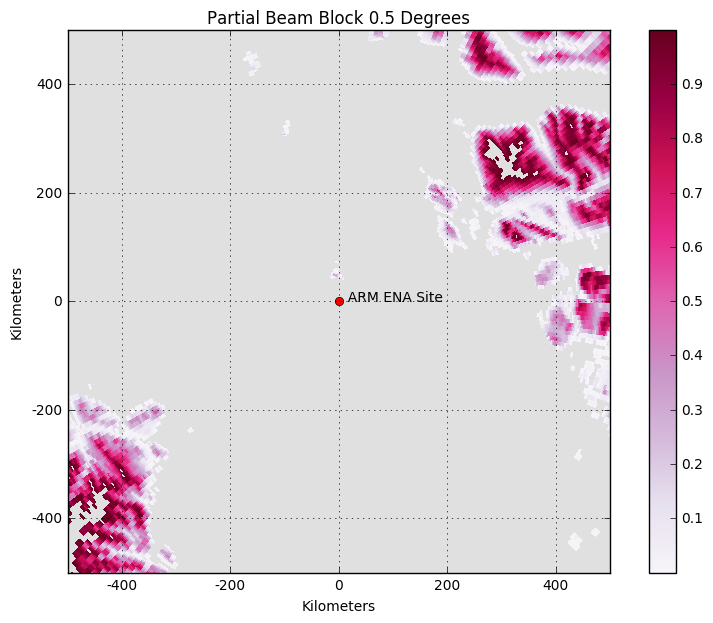

In [32]:
fig = plt.figure(figsize=(10, 7))
PBB_sea = polarvalues < 0.1
PBB_masked_data = np.ma.masked_where(PBB_sea, PBB)
ax, dem = wrl.vis.plot_ppi(PBB_masked_data, r=r,
                           az=np.degrees(coord[:, 0, 1]),
                           cmap=plt.cm.PuRd)
ax.plot(0, 0, 'ro', )
ax.grid(True)
ax.annotate('  ARM ENA Site', (0, 0))
ticks = (ax.get_xticks()/1000).astype(np.int)
ax.set_xticklabels(ticks)
ticks = (ax.get_yticks()/1000).astype(np.int)
ax.set_yticklabels(ticks)
ax.set_title('Partial Beam Block 0.5 Degrees')
ax.set_xlabel("Kilometers")
ax.set_ylabel("Kilometers")
ax.set_axis_bgcolor('#E0E0E0')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
plt.colorbar(dem, ax=ax)
plt.savefig('/home/zsherman/beam_block/images/PBB_0_5deg.png', bbox_inches='tight')
plt.show()

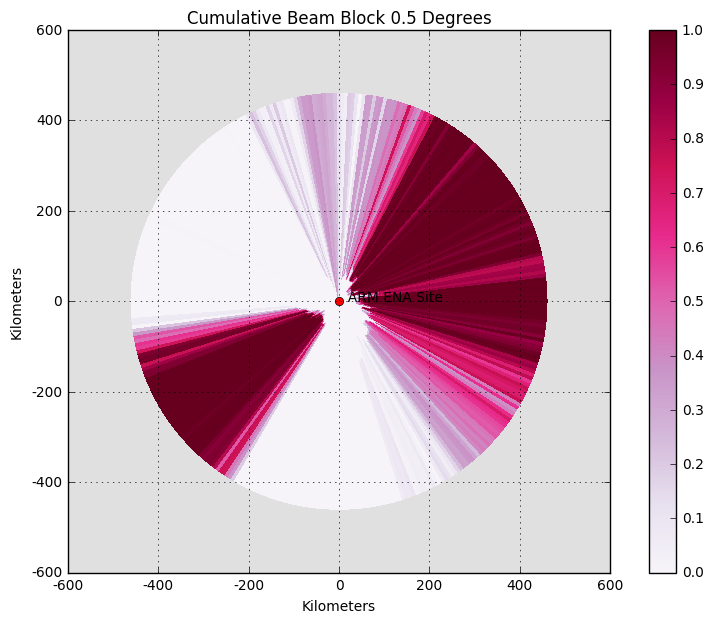

In [33]:
fig = plt.figure(figsize=(10, 7))
#CBB_sea = polarvalues < 0.1
#CBB_masked_data = np.ma.masked_where(CBB_sea, CBB)

ax2, dem = wrl.vis.plot_ppi(CBB, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.PuRd, vmin=0, vmax=1)
#wrl.vis.plot_ppi_crosshair(dem, 10)
#ax2.set_xlim(-5000, 8000)
#ax2.set_ylim(-10000, 2000)
ax2.plot(0, 0, 'ro', )
ax2.grid(True)
ax2.annotate('  ARM ENA Site', (0, 0))
ticks = (ax2.get_xticks()/1000).astype(np.int)
ax2.set_xticklabels(ticks)
ticks = (ax2.get_yticks()/1000).astype(np.int)
ax2.set_yticklabels(ticks)
ax2.set_title('Cumulative Beam Block 0.5 Degrees')
ax2.set_xlabel("Kilometers")
ax2.set_ylabel("Kilometers")
ax2.set_axis_bgcolor('#E0E0E0')
plt.colorbar(dem, ax=ax2)
plt.savefig('/home/zsherman/beam_block/images/CBB_0_5deg.png', bbox_inches='tight')
plt.show()

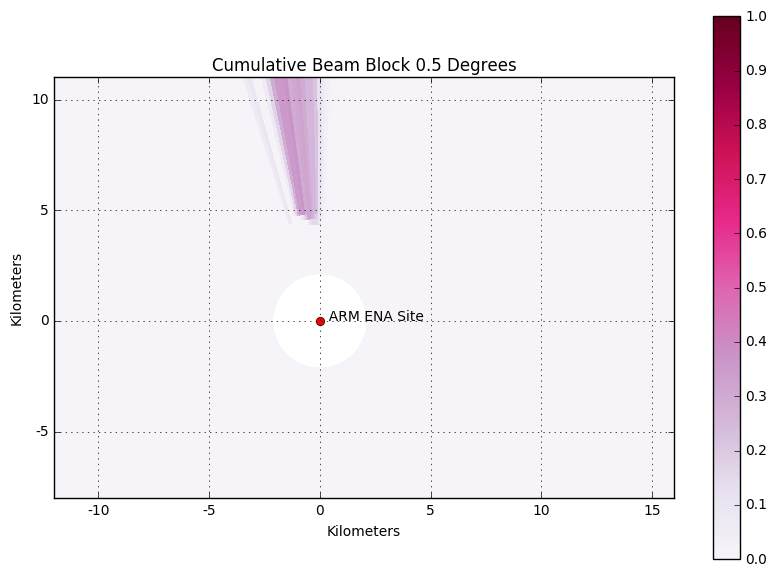

In [34]:
fig = plt.figure(figsize=(10, 7))
CBB_sea = polarvalues < 0.1
CBB_masked_data = np.ma.masked_where(CBB_sea, CBB)

ax2, dem = wrl.vis.plot_ppi(CBB, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.PuRd, vmin=0, vmax=1)
ax2.set_xlim(-12000, 16000)
ax2.set_ylim(-8000, 11000)
ax2.plot(0, 0, 'ro', )
ax2.grid(True)
ax2.annotate('  ARM ENA Site', (0, 0))
ticks = (ax2.get_xticks()/1000).astype(np.int)
ax2.set_xticklabels(ticks)
ticks = (ax2.get_yticks()/1000).astype(np.int)
ax2.set_yticklabels(ticks)
ax2.set_title('Cumulative Beam Block 0.5 Degrees')
ax2.set_xlabel("Kilometers")
ax2.set_ylabel("Kilometers")
plt.colorbar(dem, ax=ax2)
plt.savefig('/home/zsherman/beam_block/images/CBB_zoomed_0_5deg.png', bbox_inches='tight')
plt.show()

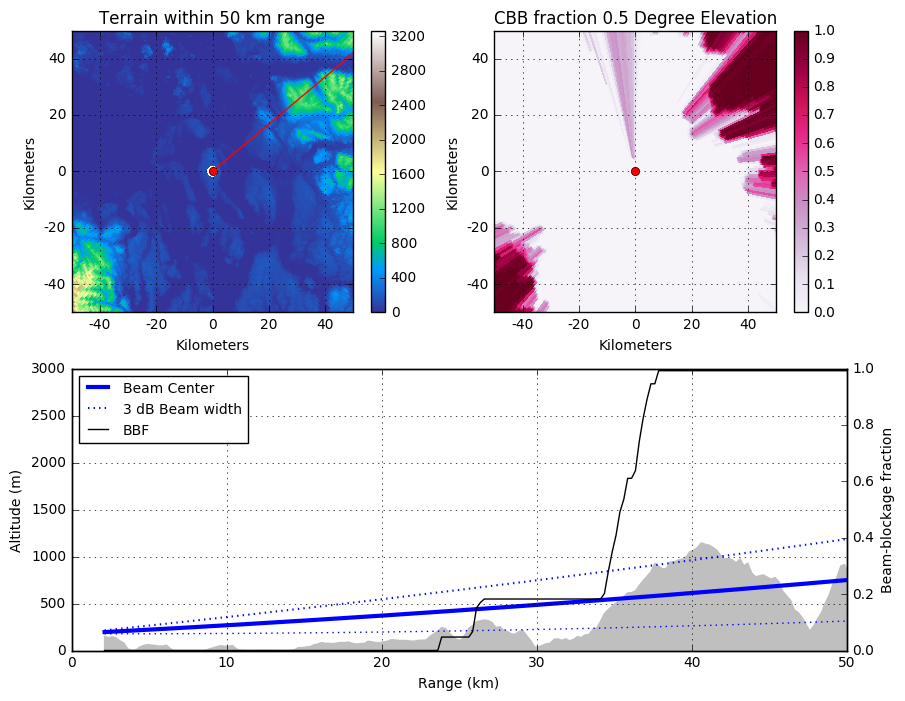

In [35]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

polar_sea = polarvalues < 0.1
polar_masked_data = np.ma.masked_where(polar_sea, polarvalues)

fig = plt.figure(figsize=(10, 8))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 50

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.terrain, vmin=0.)
ax1.plot([0, np.sin(np.radians(angle))*1e5],
         [0, np.cos(np.radians(angle))*1e5], "r-")
ax1.plot(0, 0, 'ro')
# ax1.annotate('      NEXRAD KATX Site',
             #(sitecoords[0], sitecoords[1]))
ax1.set_xlim(-50000, 50000)
ax1.set_ylim(-50000, 50000)
annotate_map(ax1, dem, 'Terrain within 50 km range')

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.PuRd, vmin=0, vmax=1)
ax2.plot(0, 0, 'ro', )
#ax2.annotate('  NEXRAD KATX Site', (sitecoords[0], sitecoords[1]))
ax2.set_xlim(-50000, 50000)
ax2.set_ylim(-50000, 50000)
annotate_map(ax2, cbb, 'CBB fraction 0.5 Degree Elevation')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., 50)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

plt.savefig('/home/zsherman/beam_block/images/3plot_seattle_50km_cbb.png',
            bbox_inches='tight')

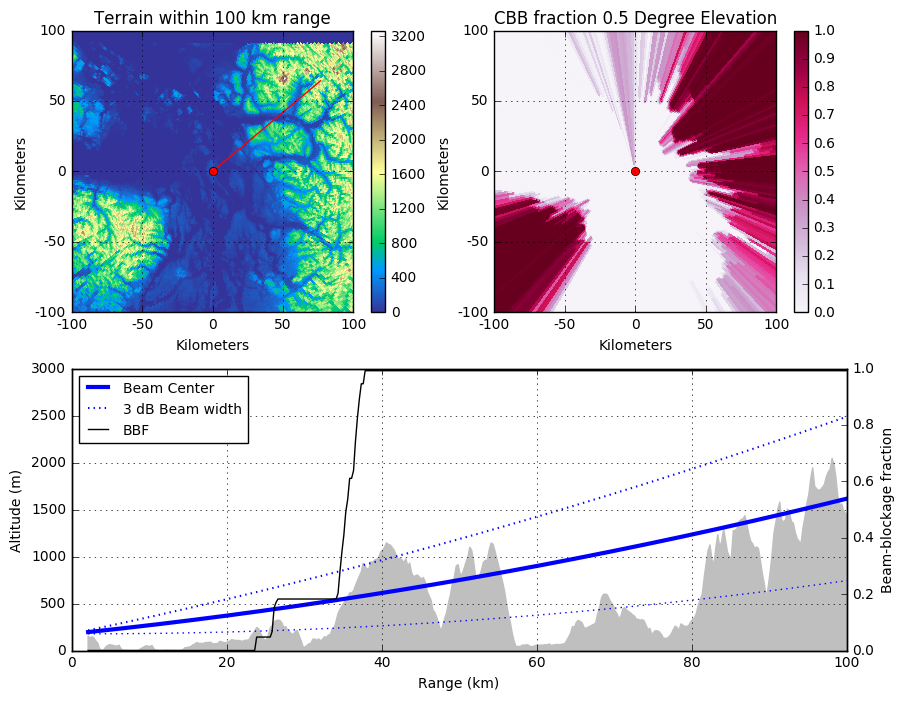

In [36]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

polar_sea = polarvalues < 0.1
polar_masked_data = np.ma.masked_where(polar_sea, polarvalues)

fig = plt.figure(figsize=(10, 8))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 50

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(0, 0, 'ro')
ax1.set_xlim(-100000, 100000)
ax1.set_ylim(-100000, 100000)
annotate_map(ax1, dem, 'Terrain within 100 km range')

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.PuRd, vmin=0, vmax=1)
ax2.plot(0, 0, 'ro', )
ax2.set_xlim(-100000, 100000)
ax2.set_ylim(-100000, 100000)
annotate_map(ax2, cbb, 'CBB fraction 0.5 Degree Elevation')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., 100)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

plt.savefig('/home/zsherman/beam_block/images/3plot_seattle_100km_cbb.png',
            bbox_inches='tight')

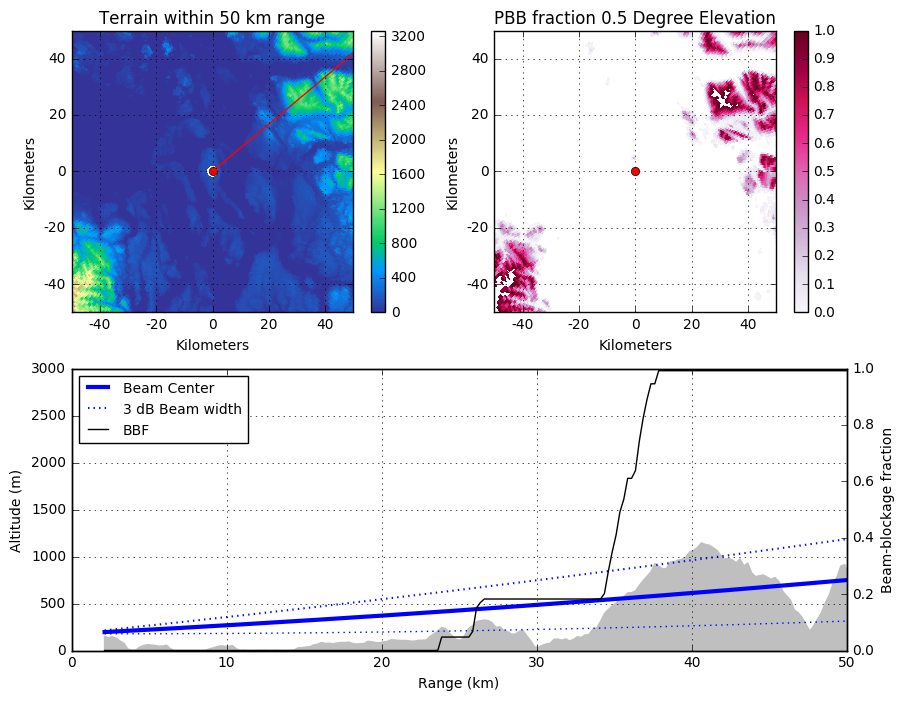

In [37]:
fig = plt.figure(figsize=(10, 8))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 50

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(0, 0, 'ro')
# ax1.annotate('      NEXRAD KATX Site',
             #(sitecoords[0], sitecoords[1]))
ax1.set_xlim(-50000, 50000)
ax1.set_ylim(-50000, 50000)
annotate_map(ax1, dem, 'Terrain within 50 km range')

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(PBB, ax=ax2, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.PuRd, vmin=0, vmax=1)
ax2.plot(0, 0, 'ro')
#ax2.annotate('  NEXRAD KATX Site', (sitecoords[0], sitecoords[1]))
ax2.set_xlim(-50000, 50000)
ax2.set_ylim(-50000, 50000)
annotate_map(ax2, cbb, 'PBB fraction 0.5 Degree Elevation')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., 50)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

plt.savefig('/home/zsherman/beam_block/images/3plot_seattle_50km_pbb.png',
            bbox_inches='tight')

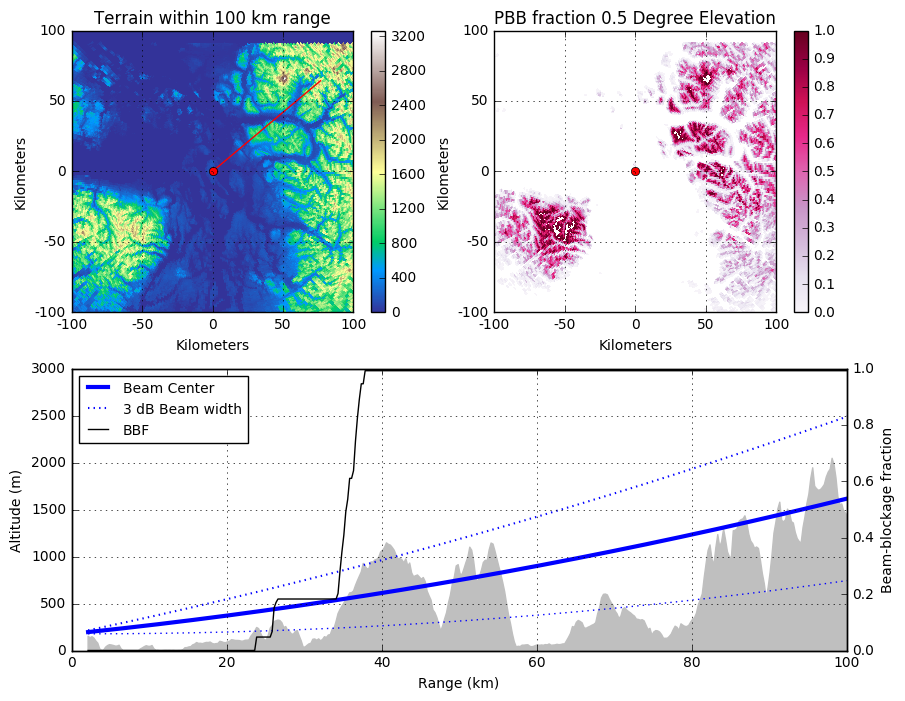

In [38]:
fig = plt.figure(figsize=(10, 8))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 50

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(0, 0, 'ro')
ax1.set_xlim(-100000, 100000)
ax1.set_ylim(-100000, 100000)
annotate_map(ax1, dem, 'Terrain within 100 km range')

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(PBB, ax=ax2, r=r,
                            az=np.degrees(coord[:, 0, 1]),
                            cmap=plt.cm.PuRd, vmin=0, vmax=1)
ax2.plot(0, 0, 'ro', )
ax2.set_xlim(-100000, 100000)
ax2.set_ylim(-100000, 100000)
annotate_map(ax2, cbb, 'PBB fraction 0.5 Degree Elevation')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., 100)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

plt.savefig('/home/zsherman/beam_block/images/3plot_seattle_100km_pbb.png',
            bbox_inches='tight')